# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import collections

%matplotlib inline
from sklearn.cross_validation import train_test_split

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)

    return img


# TODO: Fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'
classes_file = 'signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(classes_file, mode='rb') as f:
    classes = np.genfromtxt(classes_file,delimiter=',', names=True)
    
#augment the data with some distorted/scaled images from the training data
#increase the frequency for the images with lower frequency until all images have equal frequencies
counter=collections.Counter(train['labels'])
max_frequency = counter.most_common()[0][1] - 1 
#how many times each image in each label be transformed
label_multiples = np.empty([43],dtype=np.int)
for pair in counter.most_common():
    label_multiples[pair[0]] = int(max_frequency/pair[1]) + 1
    
    
X_augmented =[]
y_augmented = []
for idx in range(len(train['labels'])):
    for j in range(label_multiples[train['labels'][idx]]):
        X_augmented.append(transform_image(train['features'][idx],20,10,5,brightness=1))
        y_augmented.append(train['labels'][idx])
        
X_augmented = np.array(X_augmented)
train['features'] = np.concatenate((train['features'], X_augmented))

y_augmented = np.array(y_augmented)
train['labels'] = np.concatenate((train['labels'], y_augmented))
     
X_train, X_valid, y_train, y_valid = train_test_split(train['features'], train['labels'], test_size=0.33, random_state=42)
X_test, y_test = test['features'], test['labels']



---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples.
n_valid = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = classes.shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 106345
Number of validation examples = 52380
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

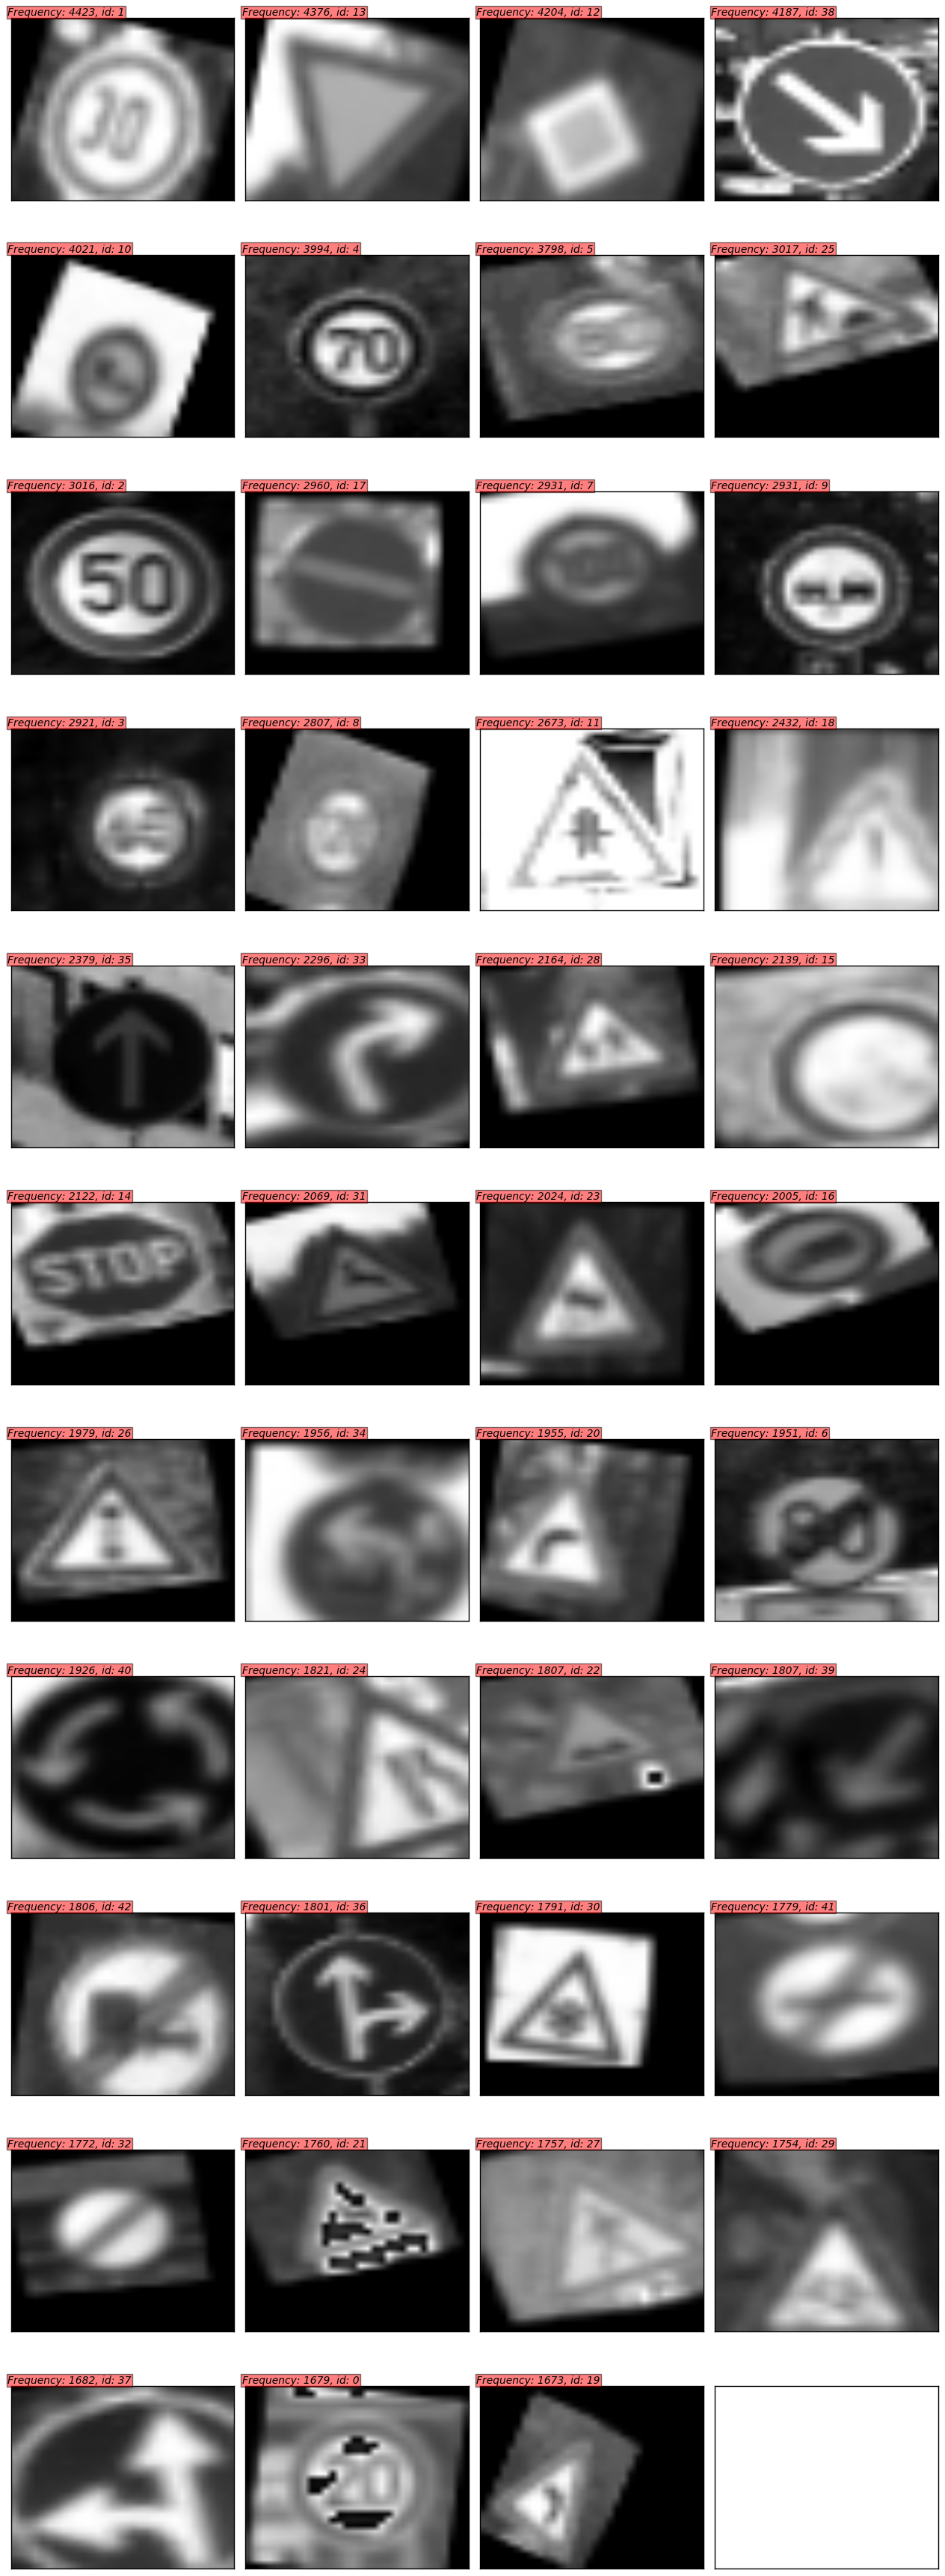

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
# Visualizations will be shown in the notebook.
%matplotlib inline



def grayscale(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


def process_image(img):
    return grayscale(img)


def normalize(x):    
    return (x - 128) / 128.0
    
def preprocess_list(x):    
    temp = np.empty([len(x),32,32,1],dtype=np.float32)
    for idx,img in enumerate(x):
        temp[idx][...,0] = process_image(img)           
    return temp

visualize = True
if(visualize == True):
    num_cols = 4
    num_rows = (int)(n_classes/num_cols) + 1
    counter = collections.Counter(y_train)
    plt.close('all')
    fig, ax = plt.subplots(num_rows,num_cols, figsize=(16, 44),subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.3, wspace=0.05)
    idx = 0
    for pair in counter.most_common():
        li = next(i for i,p in enumerate(y_train) if p  == pair[0])
        frq = 'Frequency: ' + str(pair[1])  + ', id: ' + str(pair[0])
        row = (int)(idx/num_cols)
        col = (int)(idx%num_cols)
        ax[row,col].imshow(process_image(X_train[li]), cmap='gray', aspect='auto')
        ax[row,col].text(-1, -1, frq, style='italic', bbox={'facecolor':'red', 'alpha':0.5, 'pad':1})  
        idx += 1

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

#preprocess training data
X_train = preprocess_list(X_train)
#normalize training data
X_train = normalize(X_train)

#preprocess validation data
X_valid = preprocess_list(X_valid)
#normalize validation data
X_valid = normalize(X_valid)


### Model Architecture

In [5]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    #add dropout layer
    keep_prob = tf.constant(0.7) # probability to keep units
    conv1 = tf.nn.dropout(conv1, keep_prob)

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)

    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #add dropout layer
    #keep_prob = tf.constant(0.7) # probability to keep units
    #fc2 = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

rate = 0.001
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [6]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.

MAX_EPOCHS = 50
BATCH_SIZE = 128
init_op = tf.global_variables_initializer()
saver = tf.train.Saver()

#number of no-improvement Epoches
validation_accuracy = 0
n__no_improvement = 0
no_improvement_value = 0.001
last_validation_accuracy = 0

with tf.Session() as sess:  
    sess.run(init_op)
    num_examples = len(X_train)
  
    print("Training...")
    print()
    for i in range(MAX_EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        X_valid, y_valid = shuffle(X_valid, y_valid)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        training_accuracy = evaluate(X_train, y_train)
        last_validation_accuracy = validation_accuracy
        validation_accuracy = evaluate(X_valid, y_valid)
        if(abs(validation_accuracy - last_validation_accuracy) < no_improvement_value):
            if (n__no_improvement == 3):
                print('To avoid overfitting, terminating training at Epoch: ', i)
                break                
            n__no_improvement +=1
        else:
            n__no_improvement = 0
            
                
            
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    saver.save(sess, './mymodel')
    print("Model saved")


Training...

EPOCH 1 ...
Training Accuracy = 0.526
Validation Accuracy = 0.514

EPOCH 2 ...
Training Accuracy = 0.646
Validation Accuracy = 0.630

EPOCH 3 ...
Training Accuracy = 0.710
Validation Accuracy = 0.690

EPOCH 4 ...
Training Accuracy = 0.748
Validation Accuracy = 0.723

EPOCH 5 ...
Training Accuracy = 0.778
Validation Accuracy = 0.751

EPOCH 6 ...
Training Accuracy = 0.797
Validation Accuracy = 0.767

EPOCH 7 ...
Training Accuracy = 0.805
Validation Accuracy = 0.773

EPOCH 8 ...
Training Accuracy = 0.822
Validation Accuracy = 0.784

EPOCH 9 ...
Training Accuracy = 0.827
Validation Accuracy = 0.790

EPOCH 10 ...
Training Accuracy = 0.844
Validation Accuracy = 0.803

EPOCH 11 ...
Training Accuracy = 0.850
Validation Accuracy = 0.806

EPOCH 12 ...
Training Accuracy = 0.847
Validation Accuracy = 0.802

EPOCH 13 ...
Training Accuracy = 0.869
Validation Accuracy = 0.821

EPOCH 14 ...
Training Accuracy = 0.868
Validation Accuracy = 0.820

EPOCH 15 ...
Training Accuracy = 0.874
Valid

In [7]:
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

#preprocess test data
X_test = preprocess_list(X_test)

#normalize test data
X_test = normalize(X_test)

with tf.Session() as sess:
    saver.restore(sess, './mymodel')   
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy)) 

    saver.save(sess, './mymodel')
    print("Model saved")


Test Accuracy = 0.913
Model saved


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

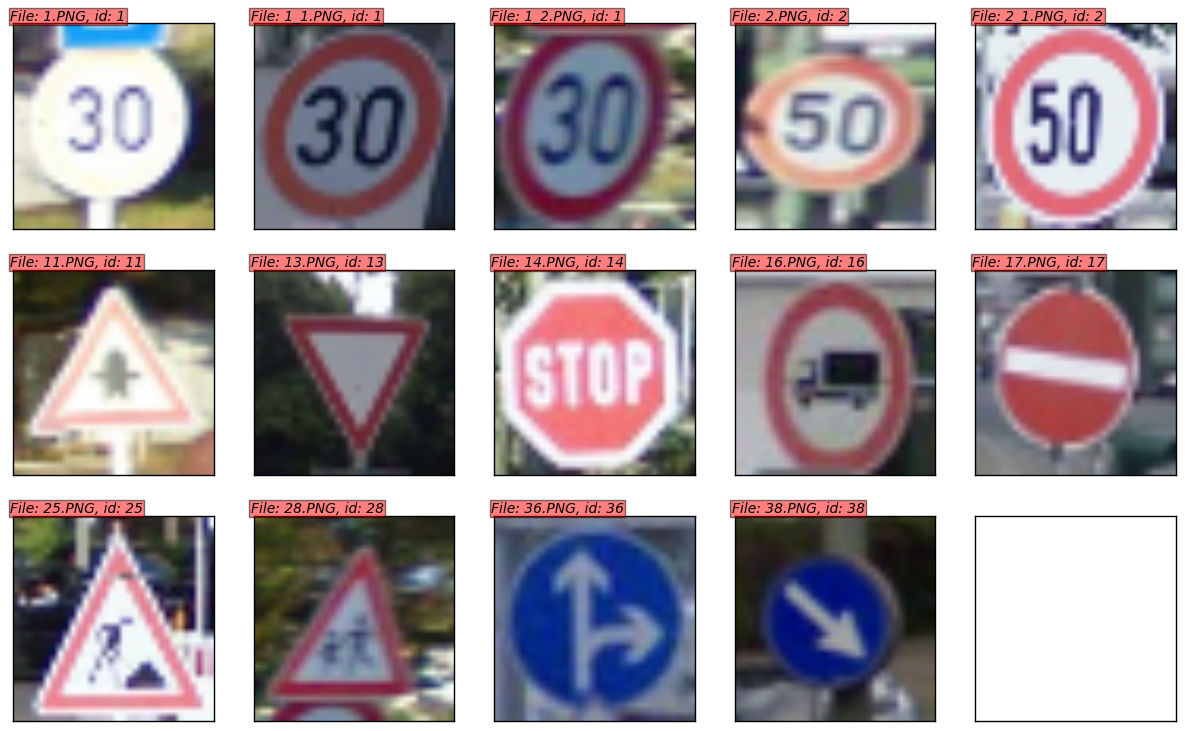

In [8]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
new_test_file = 'test_signs.csv'
with open(new_test_file, mode='rb') as f:
    new_test = np.genfromtxt(new_test_file,delimiter=',', names=True, dtype=[('File_name','|U36'),('Class_id', 'int')])
    
new_test_size = new_test.shape[0]
imgs_content = np.empty([new_test_size,32,32,4], dtype=np.float32)

for i in range(new_test_size):
    #denormalize from 0--1 to 0--255
    img = mpimg.imread(os.path.join('gsv',new_test['File_name'][i])) * 255
    #resise to 32x32
    imgs_content[i] = cv2.resize(img,(32, 32)) 

X_test_new, y_test_new = imgs_content, new_test['Class_id']

num_cols = 5
num_rows = 3
plt.close('all')
fig, ay = plt.subplots(num_rows, num_cols, figsize=(15,9),subplot_kw={'xticks': [], 'yticks': []})
idx = 0
for i in range(new_test_size):
    id =  'File: '+ new_test['File_name'][i] + ', id: ' + str(y_test_new[i])
    row = (int)(idx/num_cols)
    col = (int)(idx%num_cols)
    ay[row,col].imshow(X_test_new[i]/255.0, aspect='auto')
    ay[row,col].text(-1, -1, id, style='italic', bbox={'facecolor':'red', 'alpha':0.5, 'pad':1})  
    idx += 1




### Predict the Sign Type for Each Image

In [9]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

#preprocess test data
X_test_new = preprocess_list(X_test_new)

#normalize test data
X_test_new = normalize(X_test_new)

valid_predictions = 0

with tf.Session() as sess:
    saver.restore(sess, './mymodel')   
    for i in range (new_test_size):
        test_accuracy = evaluate(X_test_new[i:i+1], y_test_new[i:i+1])
        valid_predictions += test_accuracy
        print("Test Accuracy = {:.3f}".format(test_accuracy))       

    

Test Accuracy = 1.000
Test Accuracy = 1.000
Test Accuracy = 1.000
Test Accuracy = 0.000
Test Accuracy = 1.000
Test Accuracy = 0.000
Test Accuracy = 1.000
Test Accuracy = 1.000
Test Accuracy = 1.000
Test Accuracy = 1.000
Test Accuracy = 1.000
Test Accuracy = 1.000
Test Accuracy = 1.000
Test Accuracy = 0.000


### Analyze Performance

In [11]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print("Model accuracy: {:.3f}".format(valid_predictions/new_test_size))

Model accuracy: 0.786


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

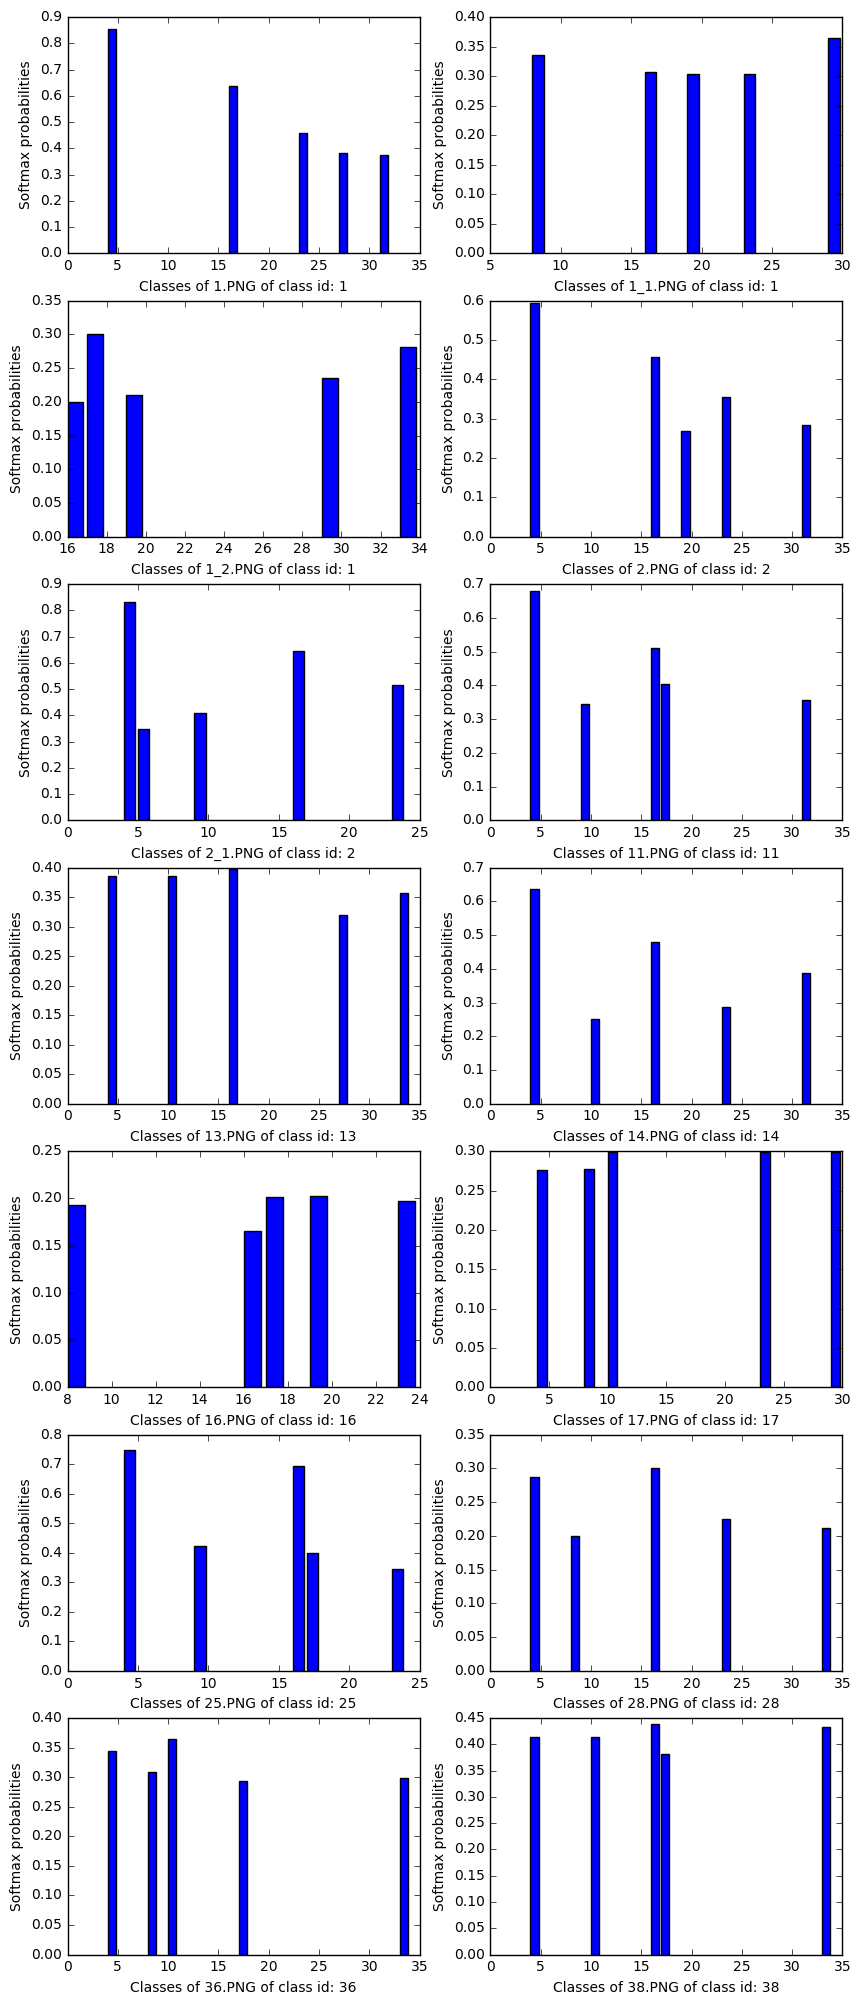

In [12]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
               
init_x = tf.global_variables_initializer()
num_cols = 2
num_rows = 7
idx = 0

with tf.Session() as sess:
    #couldn't avoid this
    sess.run(init_x)
    saver.restore(sess,'./mymodel')
    output = sess.run(logits,feed_dict={x:X_test_new,y:y_test_new})
    output = sess.run(tf.nn.top_k(output, k=5))    

    fig, ay = plt.subplots(num_rows, num_cols, figsize=(10,25))
   
    for i in range(new_test_size):
        id =  'Classes of ' + str(new_test['File_name'][i]) + ' of class id: ' + str(new_test['Class_id'][i])
        row = (int)(idx/num_cols)
        col = (int)(idx%num_cols)
        ay[row,col].bar(output[1][i],output[0][i])
        ay[row,col].set_xlabel(id)
        ay[row,col].set_ylabel('Softmax probabilities')
        idx += 1
    #print(output)


> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 